In [1]:
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs, make_moons
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import ConfusionMatrixDisplay
matplotlib.rcParams['contour.negative_linestyle']='solid'

# Example settings

n_samples=300
outliers_fraction=0.15
n_outliers=int(outliers_fraction * n_samples)
n_inliers=n_samples - n_outliers

In [2]:
# Define outlier/ anomaly detection methods to be compared
anomaly_algorithms=[
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel='rbf', gamma=0.1)),
    ("Isolation Forest", IsolationForest(contamination=outliers_fraction, random_state=42)),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction))
]

# Define datasets without outliers
blobs_params=dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets=[
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, 0.3], **blobs_params)[0],
    4. * (make_moons(n_samples=n_inliers, noise=0.05, random_state=0)[0] - np.array([0.5, 0.25])),
    14. * (np.random.RandomState(42).rand(n_inliers, 2) - 0.5)
]

In [3]:
# Define y values as 1 for inliers and 0 for outliers
y_true = np.concatenate([np.ones(n_inliers), (-1) * np.ones(n_outliers)])
# Compare given classifiers under given settings
xx, yy=np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))
rng=np.random.RandomState(42)

In [4]:
# ROC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
def roc(y_pred, y_true, ax):
    roc_auc = roc_auc_score(y_true, y_pred)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    ax.plot(fpr, tpr, label='Model (auc = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xticks(())
    ax.set_yticks(())
    ax.legend(loc="lower right")

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def confusion(y_pred, y_true, ax):
    cm = confusion_matrix(y_true, y_pred, labels=[1, -1])
    ax.set_xticks(())
    ax.set_yticks(())
    sns.heatmap(cm, annot=True, cbar=False, fmt='g', ax = ax); #annot=True to annotate cells

Robust covariance EllipticEnvelope(contamination=0.15)
One-Class SVM OneClassSVM(gamma=0.1, nu=0.15)
Isolation Forest IsolationForest(contamination=0.15, random_state=42)
Local Outlier Factor LocalOutlierFactor(contamination=0.15, n_neighbors=35)
Robust covariance EllipticEnvelope(contamination=0.15)
One-Class SVM OneClassSVM(gamma=0.1, nu=0.15)
Isolation Forest IsolationForest(contamination=0.15, random_state=42)
Local Outlier Factor LocalOutlierFactor(contamination=0.15, n_neighbors=35)
Robust covariance EllipticEnvelope(contamination=0.15)
One-Class SVM OneClassSVM(gamma=0.1, nu=0.15)
Isolation Forest IsolationForest(contamination=0.15, random_state=42)
Local Outlier Factor LocalOutlierFactor(contamination=0.15, n_neighbors=35)
Robust covariance EllipticEnvelope(contamination=0.15)
One-Class SVM OneClassSVM(gamma=0.1, nu=0.15)
Isolation Forest IsolationForest(contamination=0.15, random_state=42)
Local Outlier Factor LocalOutlierFactor(contamination=0.15, n_neighbors=35)
Robust covar

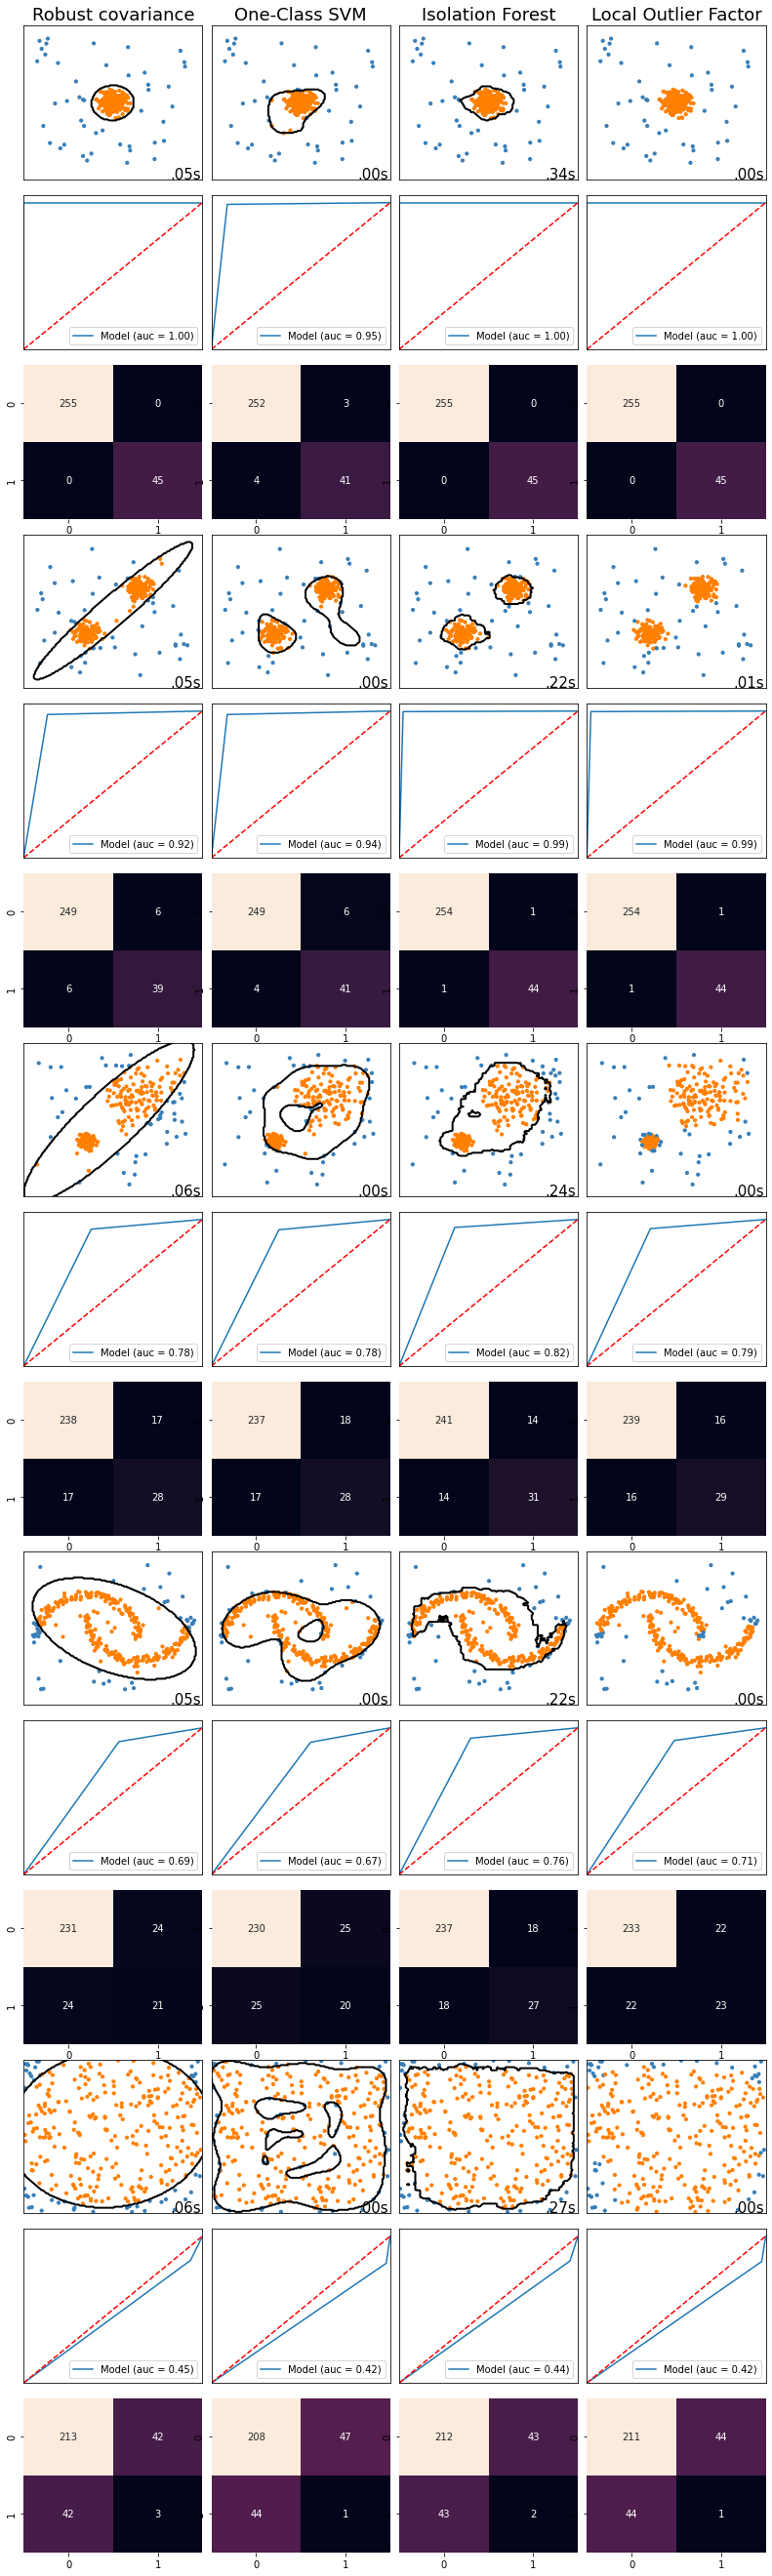

In [6]:
y = []
fig, axs = plt.subplots(nrows=5*3, ncols=4, figsize=(len(anomaly_algorithms) * 2 + 3, 3 * 12.5))
plt.subplots_adjust(left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.1)

for i_dataset, X in enumerate(datasets):
    
    # add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)
    
    for j_alg, alg in enumerate(anomaly_algorithms):
        name, algorithm = alg[0], alg[1]
        print(name, algorithm)
        t0=time.time()
        algorithm.fit(X)
        t1=time.time()
        ax = axs[3 * i_dataset][j_alg]
        if i_dataset == 0:
            ax.set_title(name, size=18)
        # fit the data and tag outliers
        if name == 'Local Outlier Factor':
            y_pred=algorithm.fit_predict(X)
        else:
            y_pred=algorithm.fit(X).predict(X)
        y.append(y_pred)
        # plot the levels lines and the points
        if name != "Local Outlier Factor":
            Z=algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z=Z.reshape(xx.shape)
            ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
        colors=np.array(["#377eb8", '#ff7f00'])
        
        # plot dataset
        ax.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])
        ax.set_xlim(-7, 7)
        ax.set_ylim(-7, 7)
        ax.set_xticks(())
        ax.set_yticks(())
        ax.text(0.99, 0.01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=ax.transAxes, size=15,
                 horizontalalignment='right')
        
        # plot roc and auc
        ax = axs[3 * i_dataset + 1][j_alg]
        roc(y_pred, y_true, ax)
        
        # plot confusion matrix
        ax = axs[3 * i_dataset + 2][j_alg]
        confusion(y_pred, y_true, ax)
plt.savefig('anomaly_results.png')
plt.show()

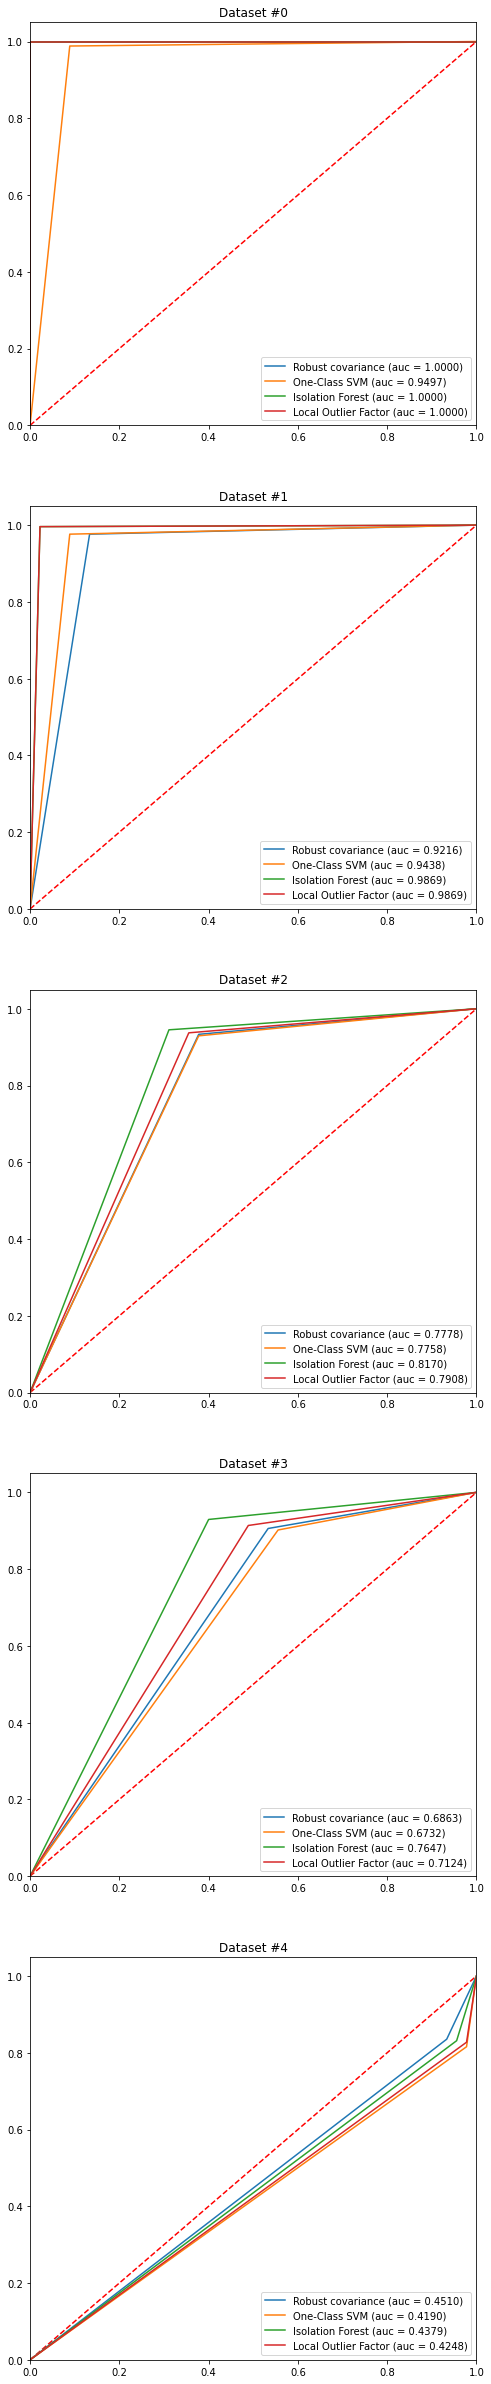

In [8]:
# ROC together
fig, axs = plt.subplots(ncols=1, nrows=len(datasets), figsize=(8, len(anomaly_algorithms) * 10 + 3))
#plt.subplots_adjust(left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01)
for i_dataset, X in enumerate(datasets):
    ax = axs[i_dataset]
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_title("Dataset #" + str(i_dataset))
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    for j, y_pred in enumerate(y[4 * i_dataset:4 * i_dataset + 4]):
        roc_auc = roc_auc_score(y_true, y_pred)
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        name = anomaly_algorithms[j][0]
        ax.plot(fpr, tpr, label='%s (auc = %0.4f)' % (name, roc_auc))
    ax.legend(loc="lower right")
plt.savefig('anomaly_roc.png')
plt.show()